# RNN - Model

In [191]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
# from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [192]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/Users/eduardomonteiro/code/mattwagon/oil_production_prediction/notebooks'

## Import the data

In [193]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = os.path.join('..', 'raw_data')
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [194]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

In [195]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


## Data cleaning

### Drop features with more than 30% NaN values

In [196]:
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)

In [197]:
df.shape

(5813, 65)

### Drop features with std = 0

In [198]:
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)

In [199]:
df.shape

(5813, 41)

### Drop corrected features

In [200]:
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)

### Drop choke features

In [201]:
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)

### Drop correlated features

In [202]:
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P', 'Qliq MPFM', 'Qwat MPFM']
df.drop(columns=features_corr_drop, inplace = True)

### Drop features in remove dictionary

In [203]:
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", "Downhole Gauge T", "Downhole Gauge P"}

In [204]:
df.drop(columns=remove, inplace=True)

### Drop the Date

In [205]:
df.drop(columns='Date', inplace=True)

## Impute features with <30% NaN values

In [206]:
for feature in df.columns:
    df[feature].replace(np.nan, df[feature].median(), inplace=True)

In [207]:
df.isnull().sum()

WHT                0
WHP                0
Tubing Gradient    0
Service Line P     0
Sand Raw           0
Qoil MPFM          0
Qgas MPFM          0
MPFM WCT           0
MPFM Venturi dP    0
MPFM T             0
MPFM CF GOR        0
Manifold T         0
Manifold P         0
Jumper T           0
Choke Opening      0
Annulus P          0
dtype: int64

## Visualising the Time Series

In [208]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = 3 

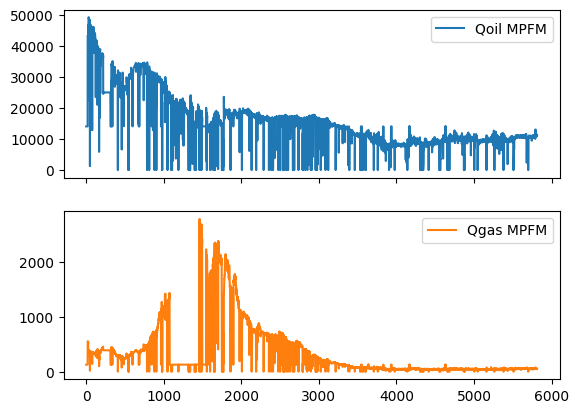

In [209]:
plot_cols = [TARGET, 'Qgas MPFM']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

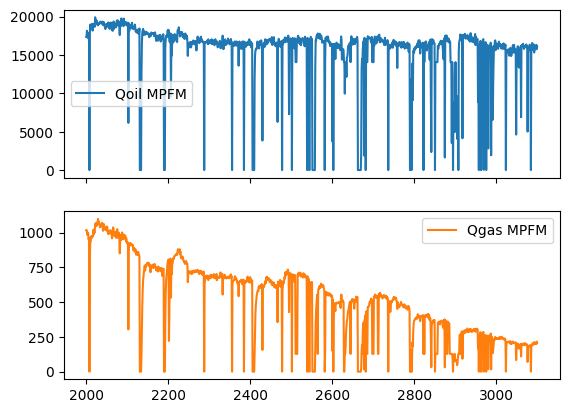

In [210]:
zoomed_slice = slice(2000,3100)

plot_features = df.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

## Prepare the dataset

### The big picture

Step 1: Cross validation in time series (folds):
    - we'll create folds and train/evaluate our LSTM on these different folds about the robustness of the neural network

Step 2: Holdout method within each fold (train-test-split) to:
    - fit the model on the train set;
    - and evaluate it on the test set;
    - always split the train set chronologically before the test set
    
Step 3: Sampling sequences in both the train set and the test set

### Creating folds for cross-validation

In [211]:
df_LSTM = df[['MPFM Venturi dP', 'WHT', 'Qoil MPFM']]
df_LSTM

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
5808,1687.935181,51.966740,10925.670806
5809,1719.284912,51.968021,11142.564473
5810,1742.380127,51.972717,11140.120568
5811,1729.632324,51.982071,11400.139595


In [212]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 365 * 6 # six years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 91 # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [213]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    fold_list = []
    
    
    for i in range(0, len(df), fold_stride):
        if i + fold_length >= len(df):
            break
        fold_list.append(df[i:fold_length])
    
    return fold_list

In [214]:
folds = get_folds(df_LSTM, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 40 folds.
Each fold has a shape equal to (2190, 3).


### Temporal Train/Test Split

Focus on 1 fold for the moment:

In [215]:
fold = folds[0]
fold

,MPFM Venturi dP,WHT,Qoil MPFM
0,1672.997986,51.247467,14065.431937
1,1672.997986,51.247467,14065.431937
2,1672.997986,51.247467,14065.431937
3,1672.997986,51.247467,14065.431937
4,1672.997986,51.247467,14065.431937
...,...,...,...
2185,4440.488770,50.234428,17033.866361
2186,4339.430664,50.448097,17049.719495
2187,4462.657715,50.312836,17144.442110
2188,4526.409668,50.242947,17705.125916


Split the fold above chronologically into a train dataframe and a test dataframe

In [216]:
INPUT_LENGTH = 14 #two weeks

In [217]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    fold_train = fold[0: round(train_test_ratio * len(fold))]
    fold_test = fold[round(train_test_ratio * len(fold)) - input_length:]
    
    return fold_train, fold_test

In [218]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

### Create (X,y) sequences

In [219]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 3
INPUT_LENGTH = 14 days = 2 weeks


In [220]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


In [221]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    random_number = np.random.randint(0,len(fold) - (input_length + output_length) + 1)

    X_i = fold.iloc[random_number : random_number + input_length]
    y_i = fold.iloc[random_number + input_length : random_number + input_length + output_length][[TARGET]]
    
    return (X_i, y_i)

In [222]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [223]:
# Advanced check 😈 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

In [224]:
X_train_i.shape

(14, 3)

### Scanning chronologically

Let's scan the fold with a temporal stride of 1 day (the minimum one)

In [225]:
SEQUENCE_STRIDE = 1

In [226]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [227]:
print("FOLD_LENGTH") 
print(f"= {int(FOLD_LENGTH)} days")
print(f"= {int(FOLD_LENGTH/7)} weeks")

FOLD_LENGTH
= 2190 days
= 312 weeks


In [228]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(1430, 14, 3)
(1430, 1, 1)


## Modeling

### LSTM

Create a function init_model which builds and compiles a simple Recurrent Neural Network with an LSTM layer

In [229]:
X_train.shape

(1430, 14, 3)

In [230]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import EarlyStopping

In [231]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

#### Baseline model

In [243]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    model = models.Sequential()
    model.add(Lambda(lambda x: x[:, -1, 1, None]))
    
    adam = optimizers.Adam(learning_rate = 0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [244]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)} m3")

24/24 [==============================] - 0s 347us/step - loss: 276075424.0000 - mae: 15974.0498
- The Baseline MAE on the test set is equal to 15974.05 m3


#### Initial model from Weather prediction challenge but with batch_size=8 and epochs=150

In [534]:
def init_model(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(64, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [535]:
model_init = init_model(X_train, y_train)
model_init.summary()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_85 (Normaliza  (None, None, 3)          7         
 tion)                                                           
                                                                 
 lstm_94 (LSTM)              (None, 64)                17408     
                                                                 
 dense_80 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,480
Trainable params: 17,473
Non-trainable params: 7
_________________________________________________________________


In [536]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model: models, verbose=1) -> tuple[models, dict]:
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [537]:
model_init, history_init = fit_model(model_init)

Epoch 1/150
125/125 [==============================] - 1s 4ms/step - loss: 996291136.0000 - mae: 30744.8535 - val_loss: 365788736.0000 - val_mae: 17617.0566
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 987842432.0000 - mae: 30609.7168 - val_loss: 361047200.0000 - val_mae: 17508.2480
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 979383424.0000 - mae: 30473.9785 - val_loss: 356379552.0000 - val_mae: 17400.3770
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 971022016.0000 - mae: 30339.2207 - val_loss: 351763424.0000 - val_mae: 17292.9258
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 962692224.0000 - mae: 30204.3145 - val_loss: 347056864.0000 - val_mae: 17183.1133
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 954108608.0000 - mae: 30064.5938 - val_loss: 342353696.0000 - val_mae: 17072.1738
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 2ms/step - loss: 607360320.0000 - mae: 23744.3281 - val_loss: 165686256.0000 - val_mae: 12035.0293
Epoch 54/150
125/125 [==============================] - 0s 2ms/step - loss: 601008768.0000 - mae: 23612.7949 - val_loss: 162688048.0000 - val_mae: 11928.8428
Epoch 55/150
125/125 [==============================] - 0s 2ms/step - loss: 594697344.0000 - mae: 23481.3379 - val_loss: 159664448.0000 - val_mae: 11822.0234
Epoch 56/150
125/125 [==============================] - 0s 2ms/step - loss: 588425920.0000 - mae: 23349.9473 - val_loss: 156636800.0000 - val_mae: 11712.7012
Epoch 57/150
125/125 [==============================] - 0s 2ms/step - loss: 582194304.0000 - mae: 23218.6387 - val_loss: 153802176.0000 - val_mae: 11607.8545
Epoch 58/150
125/125 [==============================] - 0s 2ms/step - loss: 576002880.0000 - mae: 23087.4062 - val_loss: 151137520.0000 - val_mae: 11499.1240
Epoch 59/150
125/125 [==============================

125/125 [==============================] - 0s 2ms/step - loss: 329450304.0000 - mae: 17029.5977 - val_loss: 68813976.0000 - val_mae: 7420.4722
Epoch 106/150
125/125 [==============================] - 0s 2ms/step - loss: 325139520.0000 - mae: 16909.9766 - val_loss: 67915448.0000 - val_mae: 7348.2017
Epoch 107/150
125/125 [==============================] - 0s 2ms/step - loss: 320866880.0000 - mae: 16790.5098 - val_loss: 67051500.0000 - val_mae: 7277.0879
Epoch 108/150
125/125 [==============================] - 0s 2ms/step - loss: 316632608.0000 - mae: 16671.3926 - val_loss: 66221964.0000 - val_mae: 7206.1543
Epoch 109/150
125/125 [==============================] - 0s 2ms/step - loss: 312436544.0000 - mae: 16552.4648 - val_loss: 65426848.0000 - val_mae: 7135.8579
Epoch 110/150
125/125 [==============================] - 0s 2ms/step - loss: 308279104.0000 - mae: 16433.6758 - val_loss: 64665976.0000 - val_mae: 7066.0298
Epoch 111/150
125/125 [==============================] - 0s 2ms/step - l

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

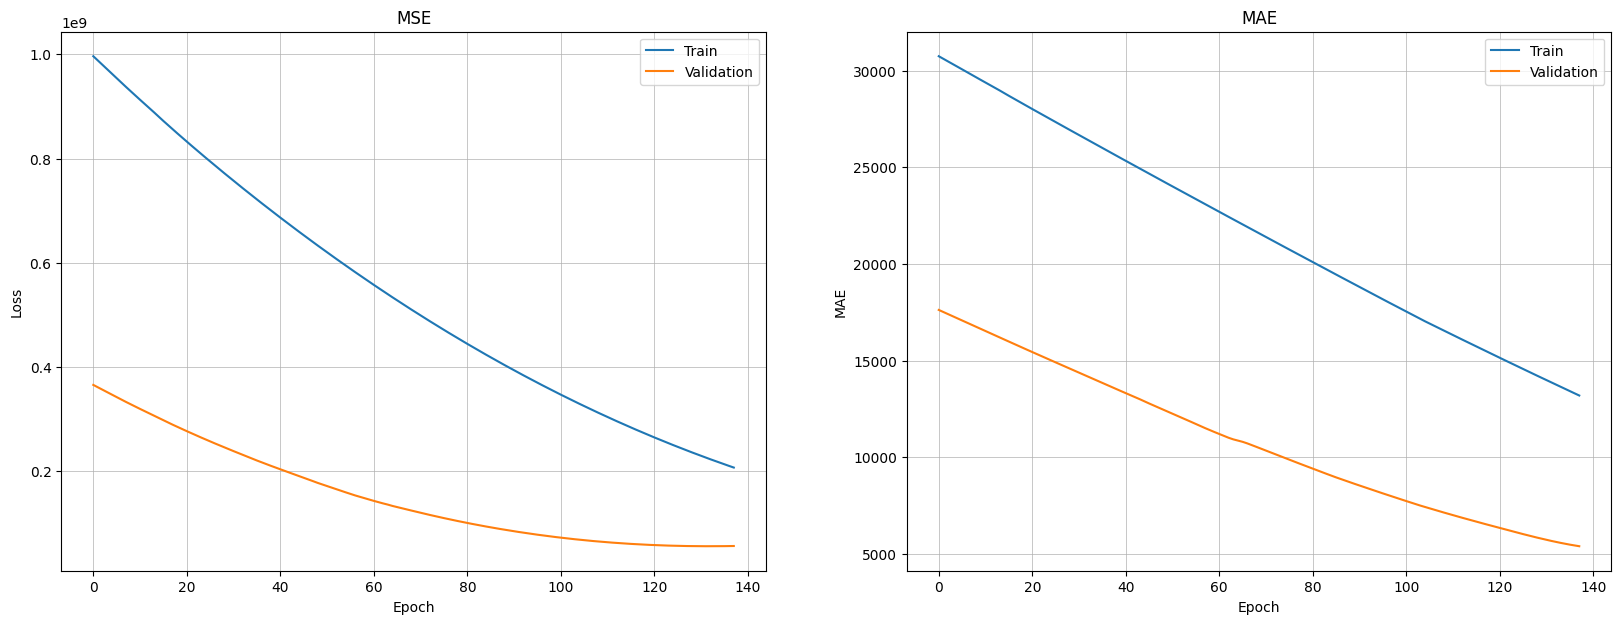

In [538]:
plot_history(history_init)

In [539]:
res = model_init.evaluate(X_test, y_test, verbose=0)
res

[24062346.0, 2532.1044921875]

In [540]:
mae_results = {}

In [541]:
mae_results['res'] = res[1]

#### Initial model with LSTM 128 neurons

In [597]:
def init_model_2(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', kernel_regularizer=L1L2(l1=0.05, l2=0.05)))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [592]:
model_2 = init_model_2(X_train, y_train)
model_2.summary()

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_94 (Normaliza  (None, None, 3)          7         
 tion)                                                           
                                                                 
 lstm_105 (LSTM)             (None, 128)               67584     
                                                                 
 dense_89 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,720
Trainable params: 67,713
Non-trainable params: 7
_________________________________________________________________


In [593]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [594]:
model_2, history_2 = fit_model(model_2)

Epoch 1/150
125/125 [==============================] - 1s 5ms/step - loss: 995353856.0000 - mae: 30729.4766 - val_loss: 368034720.0000 - val_mae: 17672.6641
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 982485184.0000 - mae: 30521.9883 - val_loss: 355892576.0000 - val_mae: 17384.7188
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 967710720.0000 - mae: 30283.9785 - val_loss: 347624704.0000 - val_mae: 17188.2754
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 953146240.0000 - mae: 30047.2422 - val_loss: 339392416.0000 - val_mae: 16990.8008
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 938537920.0000 - mae: 29807.8926 - val_loss: 331331904.0000 - val_mae: 16794.2852
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 924257216.0000 - mae: 29572.0371 - val_loss: 323479520.0000 - val_mae: 16602.0625
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 3ms/step - loss: 400445312.0000 - mae: 18973.7871 - val_loss: 87493800.0000 - val_mae: 8482.4883
Epoch 54/150
125/125 [==============================] - 0s 3ms/step - loss: 392122816.0000 - mae: 18755.5996 - val_loss: 84850048.0000 - val_mae: 8334.4170
Epoch 55/150
125/125 [==============================] - 0s 3ms/step - loss: 383932672.0000 - mae: 18538.2578 - val_loss: 82276488.0000 - val_mae: 8187.4390
Epoch 56/150
125/125 [==============================] - 0s 3ms/step - loss: 375869792.0000 - mae: 18321.6582 - val_loss: 79708168.0000 - val_mae: 8037.7236
Epoch 57/150
125/125 [==============================] - 0s 3ms/step - loss: 367930400.0000 - mae: 18106.3457 - val_loss: 77153392.0000 - val_mae: 7879.3237
Epoch 58/150
125/125 [==============================] - 0s 3ms/step - loss: 360112384.0000 - mae: 17891.9316 - val_loss: 74686856.0000 - val_mae: 7726.5518
Epoch 59/150
125/125 [==============================] - 0s 3ms/s

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

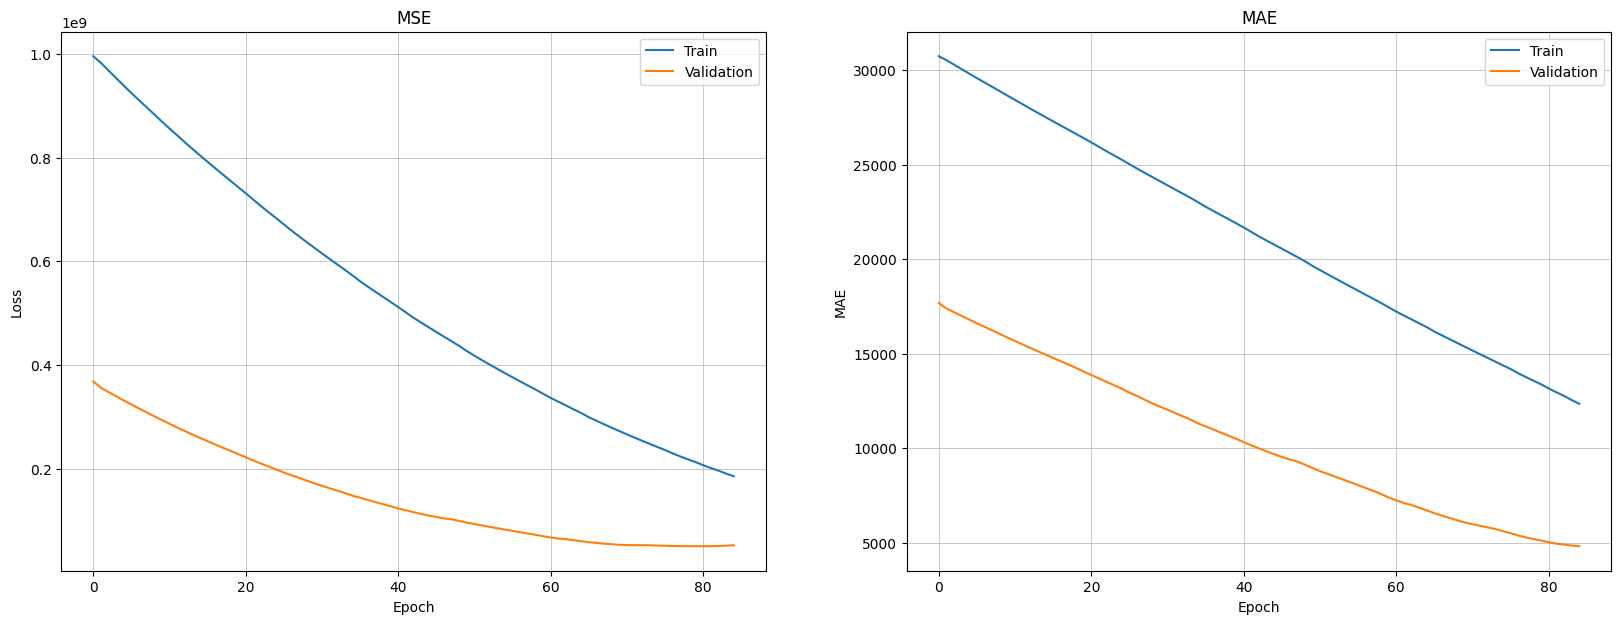

In [595]:
plot_history(history_2)

In [598]:
res2 = model_2.evaluate(X_test, y_test, verbose=0)
res2

[22585690.0, 2471.99267578125]

In [599]:
mae_results['res2'] = res2[1]

#### Initial model but with one more LSTM layer

In [637]:
def init_model_3(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
    #model.add(layers.LSTM(64, activation='tanh', return_sequences=False))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.02)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [633]:
model_3 = init_model_3(X_train, y_train)
model_3.summary()

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_100 (Normaliz  (None, None, 3)          7         
 ation)                                                          
                                                                 
 lstm_112 (LSTM)             (None, None, 128)         67584     
                                                                 
 dense_95 (Dense)            (None, None, 1)           129       
                                                                 
Total params: 67,720
Trainable params: 67,713
Non-trainable params: 7
_________________________________________________________________


In [634]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [635]:
model_3, history_3 = fit_model(model_3)

Epoch 1/150
125/125 [==============================] - 1s 5ms/step - loss: 999932480.0000 - mae: 30804.6191 - val_loss: 370406848.0000 - val_mae: 17723.3984
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 999042688.0000 - mae: 30790.6152 - val_loss: 370002304.0000 - val_mae: 17714.2617
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 998489280.0000 - mae: 30781.8301 - val_loss: 369574368.0000 - val_mae: 17703.9023
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 997961088.0000 - mae: 30773.4238 - val_loss: 369190848.0000 - val_mae: 17694.9609
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 997446144.0000 - mae: 30765.2246 - val_loss: 368866176.0000 - val_mae: 17687.5176
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 996941184.0000 - mae: 30757.1758 - val_loss: 368562464.0000 - val_mae: 17680.6582
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 3ms/step - loss: 973992384.0000 - mae: 30389.3203 - val_loss: 355933888.0000 - val_mae: 17390.3066
Epoch 54/150
125/125 [==============================] - 0s 3ms/step - loss: 973517376.0000 - mae: 30381.6426 - val_loss: 355666688.0000 - val_mae: 17384.0938
Epoch 55/150
125/125 [==============================] - 0s 3ms/step - loss: 973042176.0000 - mae: 30373.9902 - val_loss: 355399488.0000 - val_mae: 17377.8828
Epoch 56/150
125/125 [==============================] - 0s 3ms/step - loss: 972567488.0000 - mae: 30366.3125 - val_loss: 355132224.0000 - val_mae: 17371.6660
Epoch 57/150
125/125 [==============================] - 0s 3ms/step - loss: 972093312.0000 - mae: 30358.6582 - val_loss: 354865024.0000 - val_mae: 17365.4453
Epoch 58/150
125/125 [==============================] - 0s 3ms/step - loss: 971619136.0000 - mae: 30351.0059 - val_loss: 354597888.0000 - val_mae: 17359.2246
Epoch 59/150
125/125 [==============================

Epoch 105/150
125/125 [==============================] - 0s 3ms/step - loss: 949586496.0000 - mae: 29992.9434 - val_loss: 342103968.0000 - val_mae: 17066.0801
Epoch 106/150
125/125 [==============================] - 0s 3ms/step - loss: 949121600.0000 - mae: 29985.3398 - val_loss: 341840896.0000 - val_mae: 17059.8359
Epoch 107/150
125/125 [==============================] - 0s 3ms/step - loss: 948657024.0000 - mae: 29977.7461 - val_loss: 341578144.0000 - val_mae: 17053.5898
Epoch 108/150
125/125 [==============================] - 0s 3ms/step - loss: 948192896.0000 - mae: 29970.1484 - val_loss: 341315424.0000 - val_mae: 17047.3457
Epoch 109/150
125/125 [==============================] - 0s 3ms/step - loss: 947728064.0000 - mae: 29962.5488 - val_loss: 341052896.0000 - val_mae: 17041.0996
Epoch 110/150
125/125 [==============================] - 0s 3ms/step - loss: 947263680.0000 - mae: 29954.9492 - val_loss: 340790528.0000 - val_mae: 17034.8594
Epoch 111/150
125/125 [=======================

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

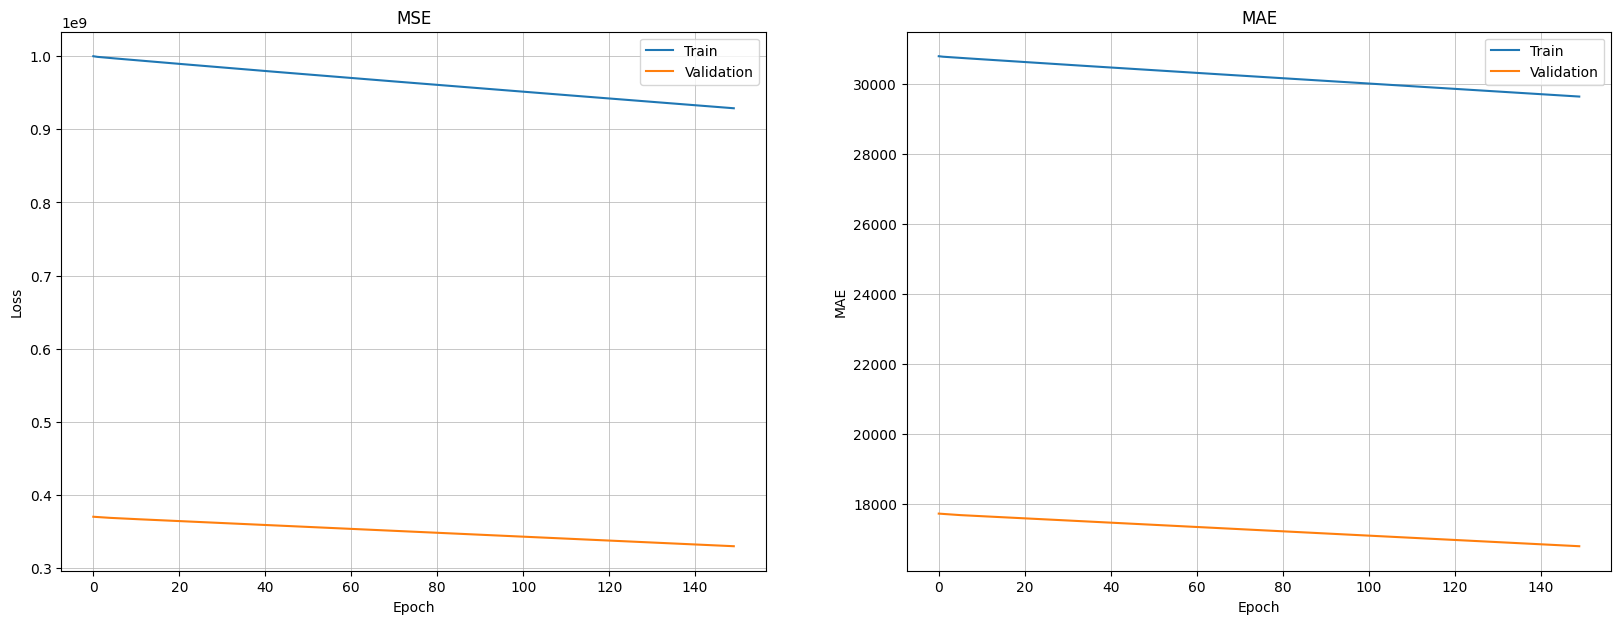

In [636]:
plot_history(history_3)

In [631]:
res3 = model_3.evaluate(X_test, y_test, verbose=0)
res3

[24016444.0, 2531.003173828125]

In [307]:
mae_results['res3'] = res3[1]

#### learning rate = 0.16

In [517]:
def init_model_4(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(64, activation='tanh'))
    model.add(layers.BatchNormalization(momentum=0.9))
    #model.add(layers.Dropout(rate=0.1))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.16)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [518]:
model_4 = init_model_4(X_train, y_train)
model_4.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_81 (Normaliza  (None, None, 3)          7         
 tion)                                                           
                                                                 
 lstm_90 (LSTM)              (None, 64)                17408     
                                                                 
 batch_normalization_21 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_76 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,736
Trainable params: 17,601
Non-trainable params: 135
_________________________________________________________________


In [519]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [520]:
model_4, history_4 = fit_model(model_4)

Epoch 1/150
125/125 [==============================] - 1s 4ms/step - loss: 557277376.0000 - mae: 19858.3301 - val_loss: 188008864.0000 - val_mae: 11564.8623
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 59149952.0000 - mae: 5289.7544 - val_loss: 92617160.0000 - val_mae: 6757.6104
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 59838632.0000 - mae: 5321.5107 - val_loss: 188243104.0000 - val_mae: 11102.1523
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 59847464.0000 - mae: 5323.8579 - val_loss: 197751600.0000 - val_mae: 11705.2676
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 59864416.0000 - mae: 5321.6499 - val_loss: 218988304.0000 - val_mae: 11981.6455
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 59859192.0000 - mae: 5321.7974 - val_loss: 344327616.0000 - val_mae: 15349.4961
Epoch 7/150
125/125 [==============================] - 0s 2ms/step - l

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

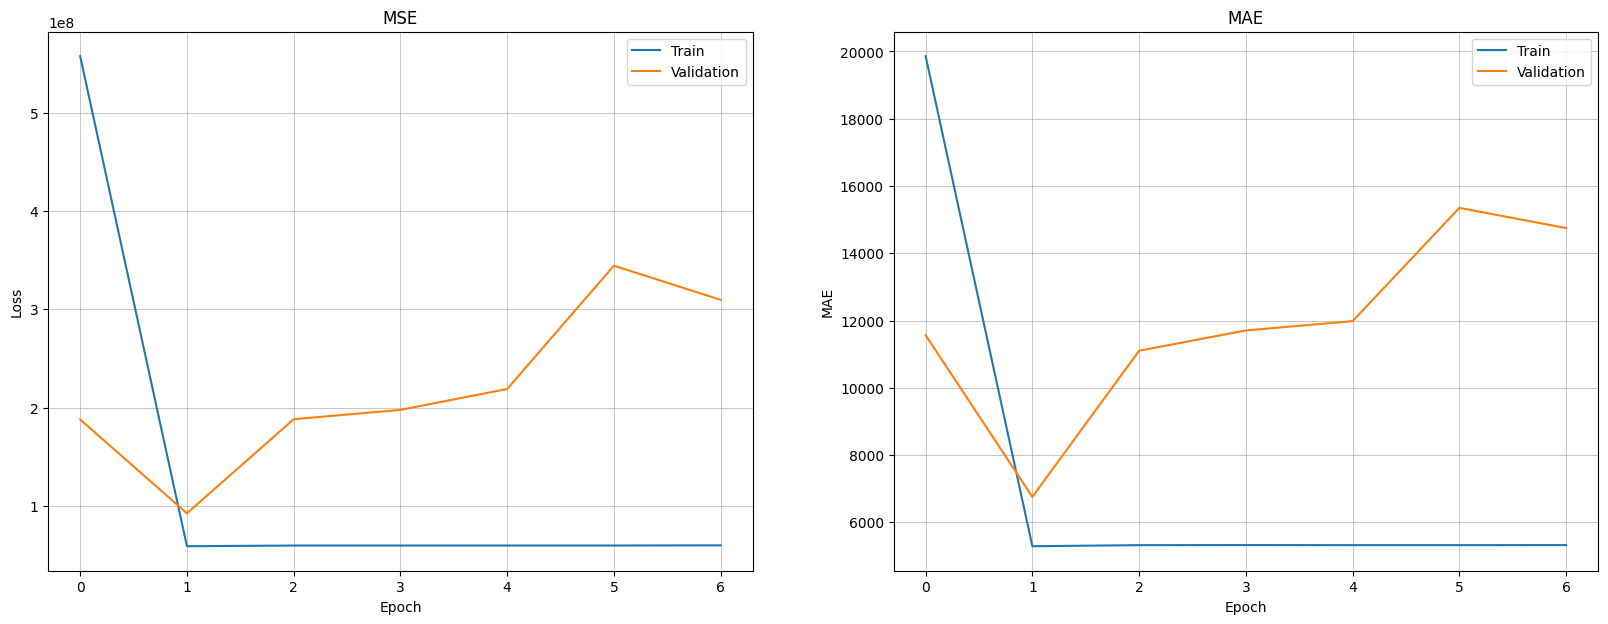

In [521]:
plot_history(history_4)

In [435]:
res4 = model_4.evaluate(X_test, y_test, verbose=0)
res4

[18725768.0, 2245.201171875]

In [436]:
mae_results['res4'] = res4[1]

In [437]:
mae_results

{'res': 2530.6484375,
 'res2': 2513.102294921875,
 'res3': 2527.82666015625,
 'res4': 2245.201171875}

#### Model to test

In [513]:
folds_complete = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
fold_complete = folds_complete[0]
(fold_train_complete, fold_test_complete) = train_test_split(fold_complete, TRAIN_TEST_RATIO, INPUT_LENGTH)

X_train_c, y_train_c = get_X_y_strides(fold_train_complete, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test_c, y_test_c = get_X_y_strides(fold_test_complete, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train_c.shape)
print(y_train_c.shape)

(1430, 14, 16)
(1430, 1, 1)


In [515]:
def init_model_4(X_train, y_train):
    
    #normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #arquitecture
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(64, activation='tanh'))
    model.add(layers.BatchNormalization(momentum=0.90))
    output_len = y_train.shape[1]
    model.add(layers.Dense(output_len, activation='linear'))
    
    #compile
    adam = optimizers.Adam(learning_rate=0.16)
    
    model.compile(loss='mse',
                 optimizer=adam,
                 metrics=['mae'])
    
    return model

In [516]:
model_5 = init_model_4(X_train_c, y_train_c)
model_5.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_80 (Normaliza  (None, None, 16)         33        
 tion)                                                           
                                                                 
 lstm_89 (LSTM)              (None, 64)                20736     
                                                                 
 dense_75 (Dense)            (None, 1)                 65        
                                                                 
Total params: 20,834
Trainable params: 20,801
Non-trainable params: 33
_________________________________________________________________


In [508]:
es = EarlyStopping(patience=5, restore_best_weights=True)

def fit_model(model):
    
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        shuffle = False,
                        batch_size=8,
                        epochs=150,
                        verbose=1,
                        callbacks=[es]
                       )
    
    return (model, history)

In [509]:
model_5, history_5 = fit_model(model_5)

Epoch 1/150
125/125 [==============================] - 2s 4ms/step - loss: 996147712.0000 - mae: 30742.6211 - val_loss: 365383552.0000 - val_mae: 17608.5098
Epoch 2/150
125/125 [==============================] - 0s 2ms/step - loss: 987228352.0000 - mae: 30599.7891 - val_loss: 360309696.0000 - val_mae: 17495.0898
Epoch 3/150
125/125 [==============================] - 0s 2ms/step - loss: 978347200.0000 - mae: 30457.2109 - val_loss: 355272736.0000 - val_mae: 17380.3711
Epoch 4/150
125/125 [==============================] - 0s 2ms/step - loss: 969549504.0000 - mae: 30315.2930 - val_loss: 350297792.0000 - val_mae: 17266.1328
Epoch 5/150
125/125 [==============================] - 0s 2ms/step - loss: 960825792.0000 - mae: 30173.9023 - val_loss: 345379584.0000 - val_mae: 17152.2715
Epoch 6/150
125/125 [==============================] - 0s 2ms/step - loss: 952168512.0000 - mae: 30032.9277 - val_loss: 340515936.0000 - val_mae: 17038.7188
Epoch 7/150
125/125 [==============================] - 0s 

Epoch 53/150
125/125 [==============================] - 0s 2ms/step - loss: 601342848.0000 - mae: 23619.6758 - val_loss: 163886560.0000 - val_mae: 11953.3467
Epoch 54/150
125/125 [==============================] - 0s 2ms/step - loss: 594925760.0000 - mae: 23486.0547 - val_loss: 161096416.0000 - val_mae: 11852.9521
Epoch 55/150
125/125 [==============================] - 0s 2ms/step - loss: 588549760.0000 - mae: 23352.4902 - val_loss: 158807520.0000 - val_mae: 11808.8242
Epoch 56/150
125/125 [==============================] - 0s 2ms/step - loss: 582215104.0000 - mae: 23219.0117 - val_loss: 153569856.0000 - val_mae: 11617.3945
Epoch 57/150
125/125 [==============================] - 0s 2ms/step - loss: 575921408.0000 - mae: 23085.6230 - val_loss: 150860640.0000 - val_mae: 11516.5869
Epoch 58/150
125/125 [==============================] - 0s 2ms/step - loss: 569669248.0000 - mae: 22952.3008 - val_loss: 148190400.0000 - val_mae: 11416.1592
Epoch 59/150
125/125 [==============================

125/125 [==============================] - 0s 2ms/step - loss: 321715616.0000 - mae: 16814.2324 - val_loss: 67213768.0000 - val_mae: 7290.6445
Epoch 106/150
125/125 [==============================] - 0s 2ms/step - loss: 317405056.0000 - mae: 16693.0957 - val_loss: 66364360.0000 - val_mae: 7218.4971
Epoch 107/150
125/125 [==============================] - 0s 2ms/step - loss: 313134112.0000 - mae: 16572.2070 - val_loss: 65550496.0000 - val_mae: 7146.9849
Epoch 108/150
125/125 [==============================] - 0s 2ms/step - loss: 308902784.0000 - mae: 16451.4648 - val_loss: 64772056.0000 - val_mae: 7075.9189
Epoch 109/150
125/125 [==============================] - 0s 2ms/step - loss: 304711264.0000 - mae: 16330.9385 - val_loss: 64028900.0000 - val_mae: 7005.5190
Epoch 110/150
125/125 [==============================] - 0s 2ms/step - loss: 300558880.0000 - mae: 16210.7471 - val_loss: 63320912.0000 - val_mae: 6935.9258
Epoch 111/150
125/125 [==============================] - 0s 2ms/step - l

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

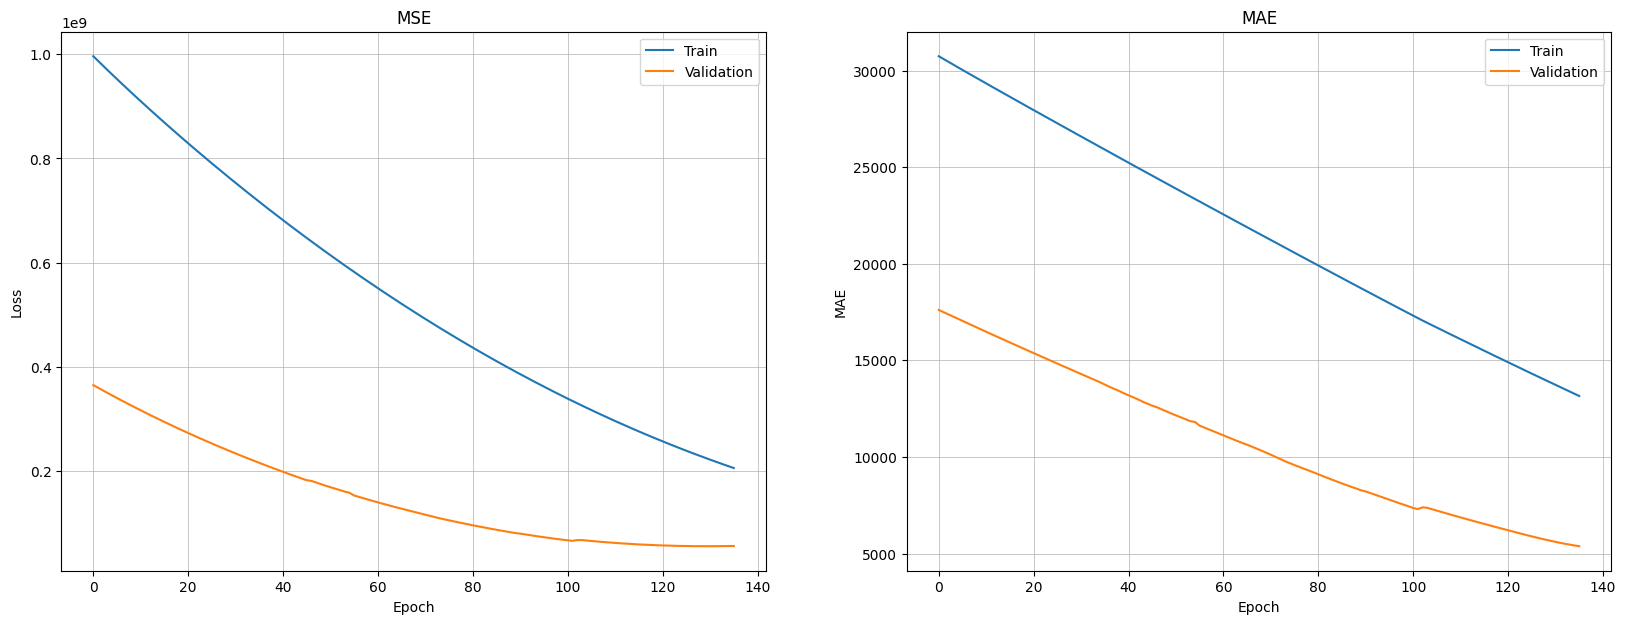

In [510]:
plot_history(history_5)

In [511]:
res5 = model_5.evaluate(X_test, y_test, verbose=0)
res5

[24163228.0, 2535.830810546875]